# Quantum model

The fair model is designed from the data set that was made in the data analysis section and his can compare with the classical fair model, for this will be with the use of neural networks to predict when there is a backorder and thus pass the data to the company responsible for the distribution and storage.

In [1]:
%load_ext autoreload
%autoreload 2


In case you don't have installed tensorflow uncomment the following cell

In [2]:
#pip install pennyane

Callign the dependencies fro mpennylane the optimizers, and methods to generate a quantum circuit

In [3]:
#improt pennylane dependnecies
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer


# load the csv files
import pandas as pd

# plot the historical acc and cost
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import clear_output
clear_output(wait=False)

import os


Load the train and test sets from the Data analysis module

In [4]:
data_train = pd.read_csv("dataset/fair_train.csv")
X_train,y_train = data_train[data_train.columns[:16]].values, data_train[data_train.columns[16]].values

data_test = pd.read_csv("dataset/classic_test.csv")
X_test,y_test = data_test[data_test.columns[:16]].values, data_test[data_test.columns[16]].values

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape)

(((2000, 16), (2000,)), ((6159, 16), (6159,)))

Init the device that called the backend default.qubit and using 4 qubits

In [5]:
n_wires = 4
dev = qml.device("default.qubit", wires=n_wires)

Define the structure of the entenglament for MERA

In [6]:
def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

Define the parameters for MERA quantum circuit

In [7]:
n_block_wires = 2
n_params_block = 2
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
n_blocks

5

Called the quantum circuit for all the data train using amplitude embedding, where the  data is encoded into the amplitudes of a quantum state. A normalized classical $N$ -dimensional datapoint $x$ is represented by the amplitudes of a $n$-qubit quantum state $\left|\psi_{x}\right\rangle$ as
$$
\left|\psi_{x}\right\rangle=\sum_{i=1}^{N} x_{i}|i\rangle
$$
where $N=2^{n}, x_{i}$ is the $i$-th element of $x$, and $|i\rangle$ is the $i$-th computational basis state. 

In [8]:
@qml.qnode(dev)
def circuit(weights, x):

    qml.AmplitudeEmbedding(x, wires=[0,1,2,3],normalize=True,pad_with=True)

    for w in weights:

        qml.MERA(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)
    
    return qml.expval(qml.PauliZ(1))

In [9]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    #print(1)
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)



In [10]:
np.random.seed(0)
num_layers = 1
weights_init = 2*np.pi * np.random.randn(num_layers,n_blocks, n_params_block, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[11.08386778  2.51426189]
  [ 6.14959212 14.07994722]
  [11.73421292 -6.14041802]
  [ 5.96958159 -0.95100539]
  [-0.64854317  2.57986647]]] 0.0


In [11]:
print(qml.draw(circuit,expansion_strategy='device',wire_order=[0,1,2,3])(weights_init,np.asarray(X_train[0])))

0: ─╭|Ψ⟩─╭X──RY(2.51)────────────────╭●──RY(5.97)──╭●──RY(-0.65)─┤     
1: ─├|Ψ⟩─╰●──RY(11.08)─╭X──RY(-6.14)─│─────────────╰X──RY(2.58)──┤  <Z>
2: ─├|Ψ⟩─╭●──RY(6.15)──│─────────────╰X──RY(-0.95)───────────────┤     
3: ─╰|Ψ⟩─╰X──RY(14.08)─╰●──RY(11.73)─────────────────────────────┤     


In [12]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]


In [13]:
y_train = np.where(y_train < 1, -1, y_train)
y_test = np.where(y_test < 1, -1, y_test)

In [14]:
from sklearn.utils import shuffle
X,y = shuffle(X_train, y_train, random_state=0)

In [15]:
from sklearn.model_selection import train_test_split

opt = NesterovMomentumOptimizer(0.4)
batch_size = 32

num_data = len(y_train)
num_train = 0.9
#train the variational classifer
weights = weights_init
bias = bias_init
print()

cost_g = []
acc_train = []
acc_test =[]
plt.show()
for i in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch.astype(np.float64), Y_train_batch.astype(np.float64))

    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    # Compute accuracy on train and validation set
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias,X_train, y_train)
    cost_g.append(cost_train)
    
    acc_train.append(acc_tra)
    acc_test.append(acc_val)
    
    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()
     
    
    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(i + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

In [ ]:
x_test = []
for x in X_test.tolist():
    if sum(x) == 0:
        x[0]=1
    x_test.append( x/ np.linalg.norm(x))
x_test[0]

array([0.4423974 , 0.5898632 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1474658 , 0.2949316 , 0.4423974 ,
       0.3686645 , 0.        , 0.07225824, 0.07299557, 0.        ,
       0.0737329 ])

In [ ]:
y_test

tensor([-1, -1, -1, ...,  1,  1,  1], dtype=int64, requires_grad=True)

In [ ]:
y_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]


In [ ]:
y_test_pred = []
for i in y_pred:
    if i < 0:
        y_test_pred.append(-1)
    else:
        y_test_pred.append(1)

Accuracy: 0.796233
Precision: 0.468750
Recall: 0.837024
F1 score: 0.600954
Cohens kappa: 0.478365
ROC AUC: 0.812051
[[3959 1071]
 [ 184  945]]


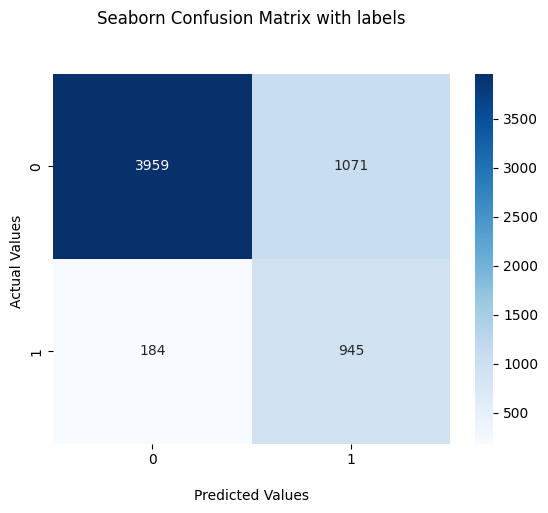

In [ ]:

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(y_test, y_test_pred)
print(test_matrix)
ax = sns.heatmap(test_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
y_pred_1 = [int(i) for i in y_test_pred ]
y_pred_1 = ["{}\n".format(i) for i in y_pred_1]
with open(r'mera_1_layers.csv', 'w') as fp:
    fp.writelines(y_pred_1)